In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
tf.__version__

'2.12.0'

In [ ]:
# Checking if i have GPU Enabled
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d amerzishminha/forest-fire-smoke-and-non-fire-image-dataset

100% 6.14G/6.14G [00:50<00:00, 141MB/s]
100% 6.14G/6.14G [00:50<00:00, 130MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/forest-fire-smoke-and-non-fire-image-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
from tensorflow import keras
from keras import callbacks
from keras import optimizers
from keras.models import Model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, BatchNormalization
from keras.models import Sequential
from keras.utils import np_utils
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
train_path = '/content/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET/train'  
val_path = '/content/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET/train'

In [ ]:
# re-size all the images to this
IMG_SIZE = [224, 224]
BATCH_SIZE = 16


In [ ]:
training_datagenarator= ImageDataGenerator(rescale=1./255,horizontal_flip=True,
                                           vertical_flip=True,shear_range=0.2,
                                           zoom_range=0.2,width_shift_range=0.2, 
                                           height_shift_range=0.2,validation_split=0.1)

In [ ]:
train=training_datagenarator.flow_from_directory(train_path,
                                                target_size=(224, 224),color_mode='rgb',
                                       class_mode='categorical', batch_size=BATCH_SIZE,subset='training')

Found 29159 images belonging to 3 classes.


In [ ]:
validation=training_datagenarator.flow_from_directory(val_path, 
                                                      target_size=(224, 224),color_mode='rgb', class_mode='categorical',
                                                batch_size=BATCH_SIZE,subset='validation')

Found 3239 images belonging to 3 classes.


In [ ]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input

In [ ]:
inceptionV3 = InceptionV3(input_shape=IMG_SIZE + [3], 
                        weights='imagenet', 
                        include_top=False)

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
inceptionV3.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [ ]:
#freezing base model weights
inceptionV3.trainable = False

In [ ]:
top_model = inceptionV3.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dense(2048, activation='relu')(top_model)
top_model = Dense(128, activation='relu')(top_model)
output_layer = Dense(3, activation='softmax')(top_model)
    
# Group the convolutional base and new fully-connected layers into a Model object.
model = Model(inceptionV3.input, output_layer)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
from keras.callbacks import EarlyStopping
callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.01,
    patience=5,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False
)

In [ ]:
history =model.fit_generator(train, validation_data=validation, epochs=50, steps_per_epoch=train.samples//BATCH_SIZE, 
                    validation_steps=validation.samples//BATCH_SIZE, callbacks = callback)

<ipython-input-21-1f1a14971053>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history =model.fit_generator(train, validation_data=validation, epochs=50, steps_per_epoch=train.samples//BATCH_SIZE,


Epoch 1/50
1822/1822 [==============================] - 889s 480ms/step - loss: 0.2785 - accuracy: 0.9053 - val_loss: 0.1905 - val_accuracy: 0.9307
Epoch 2/50
1822/1822 [==============================] - 782s 429ms/step - loss: 0.1876 - accuracy: 0.9352 - val_loss: 0.1926 - val_accuracy: 0.9363
Epoch 3/50
1822/1822 [==============================] - 771s 423ms/step - loss: 0.1677 - accuracy: 0.9417 - val_loss: 0.2160 - val_accuracy: 0.9341
Epoch 4/50
1822/1822 [==============================] - 774s 425ms/step - loss: 0.1588 - accuracy: 0.9471 - val_loss: 0.1727 - val_accuracy: 0.9390
Epoch 5/50
1822/1822 [==============================] - 768s 422ms/step - loss: 0.1363 - accuracy: 0.9536 - val_loss: 0.1686 - val_accuracy: 0.9462
Epoch 6/50
1822/1822 [==============================] - 760s 417ms/step - loss: 0.1283 - accuracy: 0.9571 - val_loss: 0.1614 - val_accuracy: 0.9437
Epoch 7/50
1822/1822 [==============================] - 764s 419ms/step - loss: 0.1230 - accuracy: 0.9604 - val_

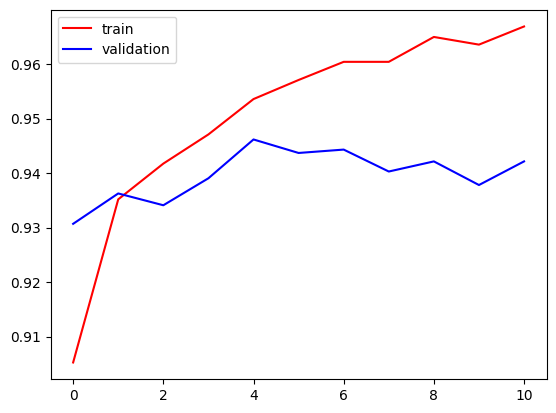

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

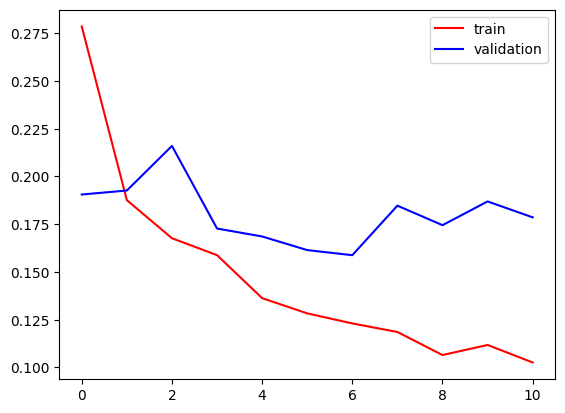

In [ ]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [ ]:
np.save('my_history.npy',history.history)

In [ ]:
model.save('fire_smoke_and_nonfire_detection.h5')

In [ ]:
from tensorflow.keras.models import load_model
model=load_model('/content/fire_smoke_and_nonfire_detection.h5')

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import PIL

In [ ]:
image_for_testing=r'/content/FOREST_FIRE_SMOKE_AND_NONFIRE_DATASET/test/non fire/NF_0.jpg'

In [ ]:
test_image=image.load_img(image_for_testing,target_size=(224,224))
test_image=image.img_to_array(test_image)
test_image=test_image/255
test_image=np.expand_dims(test_image,axis=0)
result=model.predict(test_image)


Catagories=['Smoke','Fire','Non Fire']


image_show=PIL.Image.open(image_for_testing)
plt.imshow(image_show)

plt.title(Catagories[np.argmax(result)])
plt.show()
